In [6]:
import torch
import torchvision
from torchvision import transforms, datasets, models

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math


import os 
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

rebuild_data = False

In [40]:
torch.cuda.is_available()
device = torch.device("cuda: 0")

In [7]:
train = datasets.MNIST("", train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))

In [8]:
test = train = datasets.MNIST("", train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))

In [9]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)



In [22]:
for data in trainset:
    print(len(data))
    print(data[0].shape)
    print(data[1].shape)
    print(type(trainset))
    print(len(trainset))
    break

#1000 

2
torch.Size([10, 1, 28, 28])
torch.Size([10])
<class 'torch.utils.data.dataloader.DataLoader'>
1000


In [23]:
data[0][12] #data[0] is the images

IndexError: index 12 is out of bounds for dimension 0 with size 10

In [26]:
x = data[0][0]
y = data[1][0]

In [643]:
data[0].shape

torch.Size([10, 1, 28, 28])

In [29]:
x.view(28, 28).shape

torch.Size([28, 28])

In [501]:
x

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [516]:
torch.tanh(torch.tensor(1.0))

tensor(0.7616)

tensor(0)


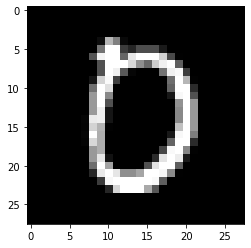

In [30]:
plt.imshow(x.view(28, 28), cmap = "gray")
#plt.show()
print(y)


In [37]:
#datasets should be balanced
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
sum = 0
for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1;
        sum += 1;
    
print([counter_dict[i]/sum*100 for i in range(10)])

[9.8, 11.35, 10.32, 10.100000000000001, 9.82, 8.92, 9.58, 10.280000000000001, 9.74, 10.09]


In [520]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__() 
        self.fc1 = nn.Linear((28*28), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.1)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.1)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.1)
        x = self.fc4(x)
                         
        return torch.sigmoid(x)
    
    
    
            
dsk = D().to(device)
print(dsk)
optimizerD = optim.SGD(dsk.parameters(), lr=0.001)


D(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [57]:
X = torch.rand((28,28))
X = X.view(-1, 28*28)
X.shape

torch.Size([1, 784])

In [500]:
output = dsk(X.to(device))
output

tensor([[0.5191]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [566]:
class G(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear((28*28), 28*28*4)
        self.fc2 = nn.Linear(28*28*4, 28*28*8)
        self.fc3 = nn.Linear(28*28*8, 28*28*4)
        self.fc4 = nn.Linear(28*28*4, 28*28)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.2)
        x = self.fc4(x)
                         
        return torch.tanh(x)
    
    
    
            
gen = G().to(device)
print(gen)
optimizerG = optim.Adam(gen.parameters(), lr=0.001)



G(
  (fc1): Linear(in_features=784, out_features=3136, bias=True)
  (fc2): Linear(in_features=3136, out_features=6272, bias=True)
  (fc3): Linear(in_features=6272, out_features=3136, bias=True)
  (fc4): Linear(in_features=3136, out_features=784, bias=True)
)


In [705]:
gen(batchOfNoise(10))

tensor([[[-1., -1., -1.,  ...,  1.,  1.,  1.]],

        [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

        [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

        ...,

        [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

        [[-1., -1., -1.,  ...,  1.,  1.,  1.]],

        [[-1., -1., -1.,  ...,  1.,  1.,  1.]]], device='cuda:0',
       grad_fn=<TanhBackward>)

In [633]:
loss_fn = nn.BCELoss()

In [567]:
q = torch.randn(28,28)
q.shape
q = q.view(-1, 1, 28*28)
q.shape


torch.Size([1, 1, 784])

In [573]:
data[0].shape
q = data[0].view(-1, 1, 784)
q.shape

torch.Size([10, 1, 784])

In [572]:
gen(q.to(device)).shape

torch.Size([10, 1, 784])

In [640]:
def batchOfNoise(batch_size):
    q = torch.rand(10, 1, 28*28)
    return q.to(device)
    

In [641]:
batchOfNoise(2).shape

torch.Size([10, 1, 784])

In [642]:
dsk(gen(batchOfNoise(10))).shape
loss_fn(dsk(gen(batchOfNoise(10))), torch.ones(10, 1, 1).to(device))

tensor(0.7098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [685]:
for epoch in range(EPOCHS):
    for _, data in enumerate(trainset):
        
        batchOfData, _ = data 
        batchOfData = batchOfData.to(device)
        print(batchOfData.shape)
        break

torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])


In [703]:
EPOCHS = 3
for epoch in range(EPOCHS):
    for _, data in enumerate(trainset):
        
        batchOfData, _ = data 
        batchOfData = batchOfData.view(-1, 1, 28*28).to(device)
        gen.zero_grad()
        fakeBatchOfImages = gen(batchOfNoise(10))
        dskLabelsOnFake = dsk(fakeBatchOfImages)
        genLoss = loss_fn(dskLabelsOnFake, torch.ones(10, 1, 1).to(device))
        genLoss.backward()
        optimizerG.step()

        dsk.zero_grad()
        dskLabelsOnFake = dsk(fakeBatchOfImages.detach())
        dskLabelsOnReal = dsk(batchOfData)
        dskLossReal = loss_fn(dskLabelsOnReal, torch.ones(10, 1, 1).to(device))
        dskLossFake = loss_fn(dskLabelsOnFake, torch.zeros(10, 1, 1).to(device))
        dskLoss = dskLossReal + dskLossFake
        dskLoss.backward()
        optimizerD.step()
    
    

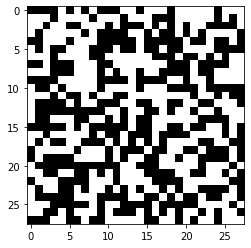

In [704]:
plt.imshow(gen(batchOfNoise(10))[0].view(28,28).cpu().detach().numpy(), cmap = "gray")